# Importing the relevant libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Preprocessing

### Importing the Database

In [4]:
raw_data = pd.read_csv('ml_datasource.csv')
print(raw_data.columns)
raw_data.head(5)

Index(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started', 'practice_exams_passed',
       'minutes_spent_on_exams', 'purchased'],
      dtype='object')


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


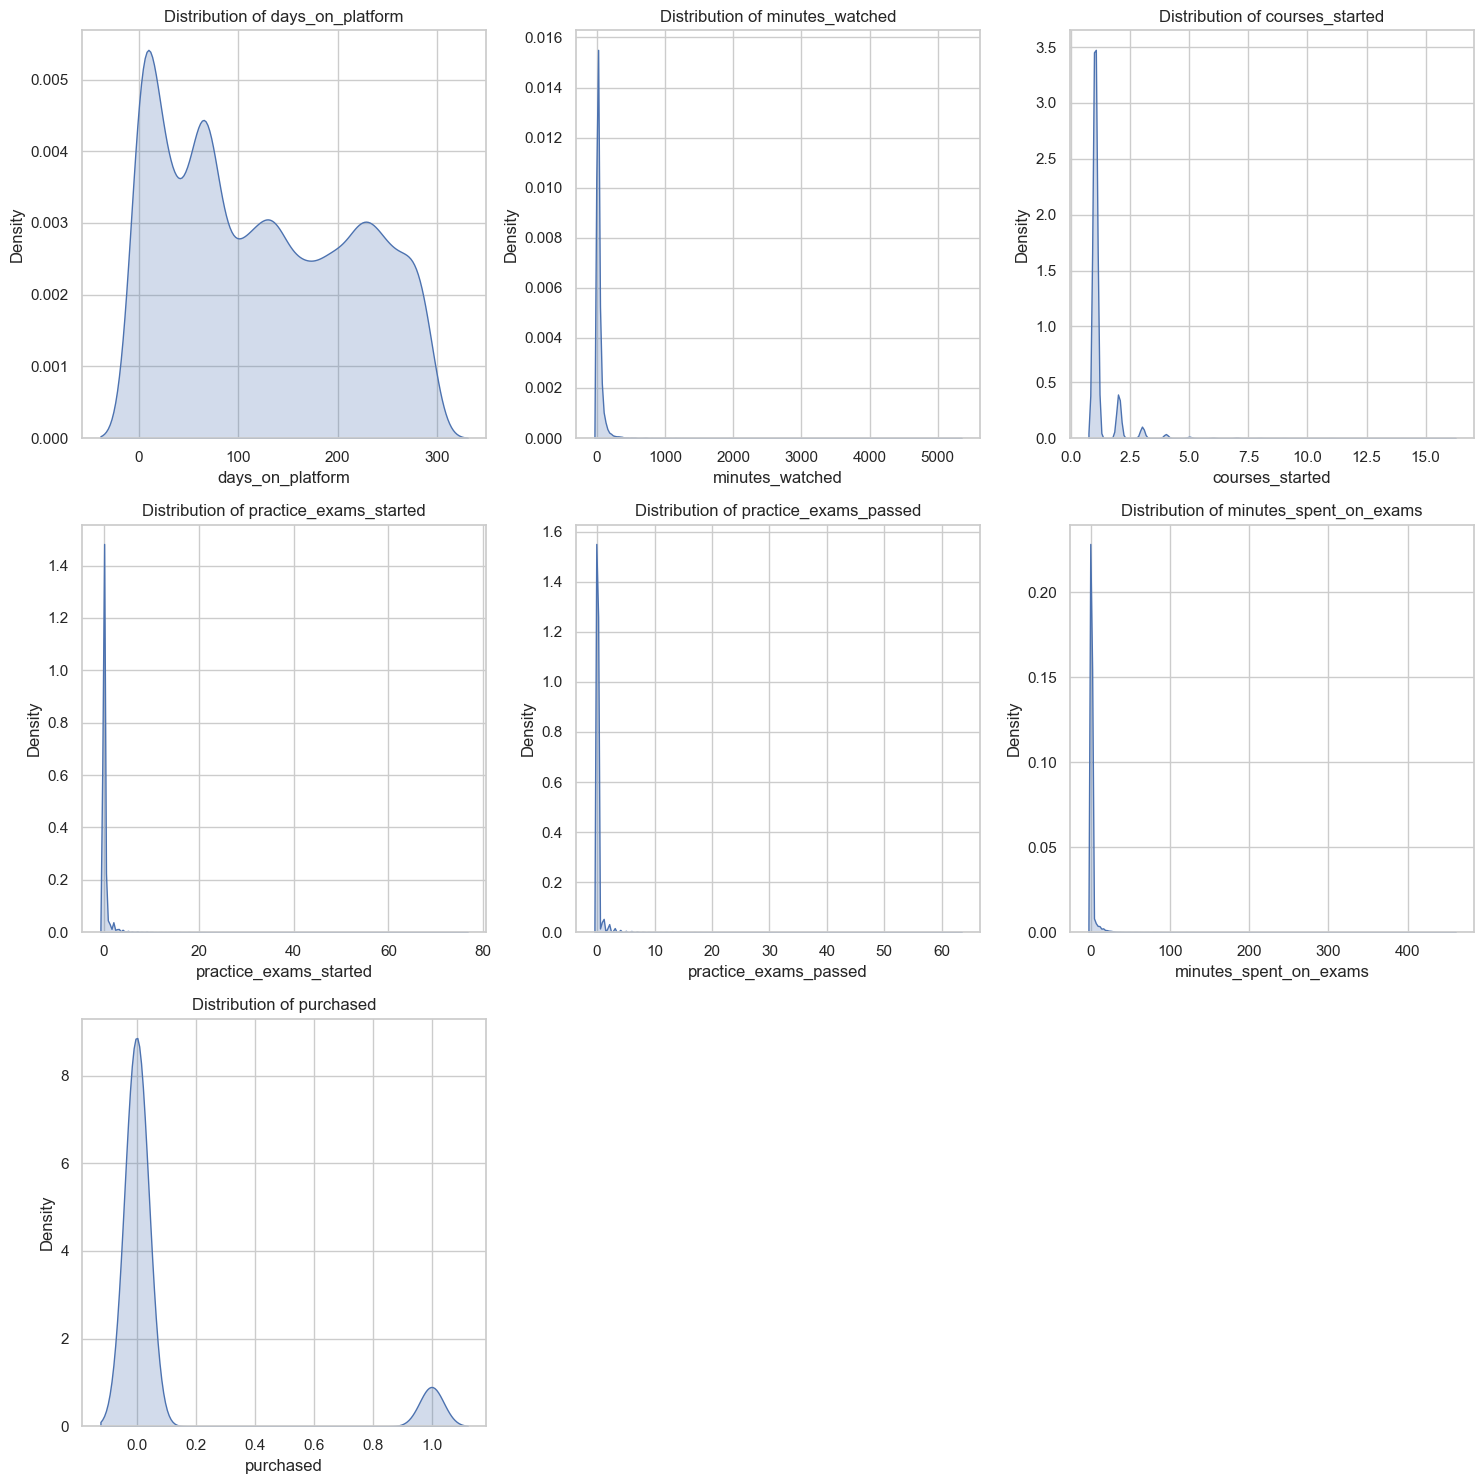

In [5]:
data = raw_data.copy()
# Set Seaborn theme
sns.set(style="whitegrid")

# Define numerical features
numerical_features = [
    "days_on_platform", "minutes_watched", "courses_started",
    "practice_exams_started", "practice_exams_passed",
    "minutes_spent_on_exams", "purchased"
]

# Determine grid size dynamically
num_features = len(numerical_features)
rows = (num_features // 3) + (num_features % 3 > 0)  # Number of rows (ceil division)
cols = min(3, num_features)  # Limit to 3 columns per row

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

# Plot KDE distributions
for i, feature in enumerate(numerical_features):
    sns.kdeplot(data[feature], ax=axes[i], fill=True)
    axes[i].set_title(f"Distribution of {feature}")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Removing Outliers

In [6]:
# Step 1: Filter out outliers
data_no_outliers = data[
    (data["minutes_watched"] <= 1000) &
    (data["courses_started"] <= 10) &
    (data["practice_exams_started"] <= 10) &
    (data["minutes_spent_on_exams"] <= 40)
]

# Step 2: Display the shape of the data before and after filtering
print(f"Original data shape: {data.shape}")
print(f"Filtered data shape: {data_no_outliers.shape}")



Original data shape: (17761, 8)
Filtered data shape: (17626, 8)


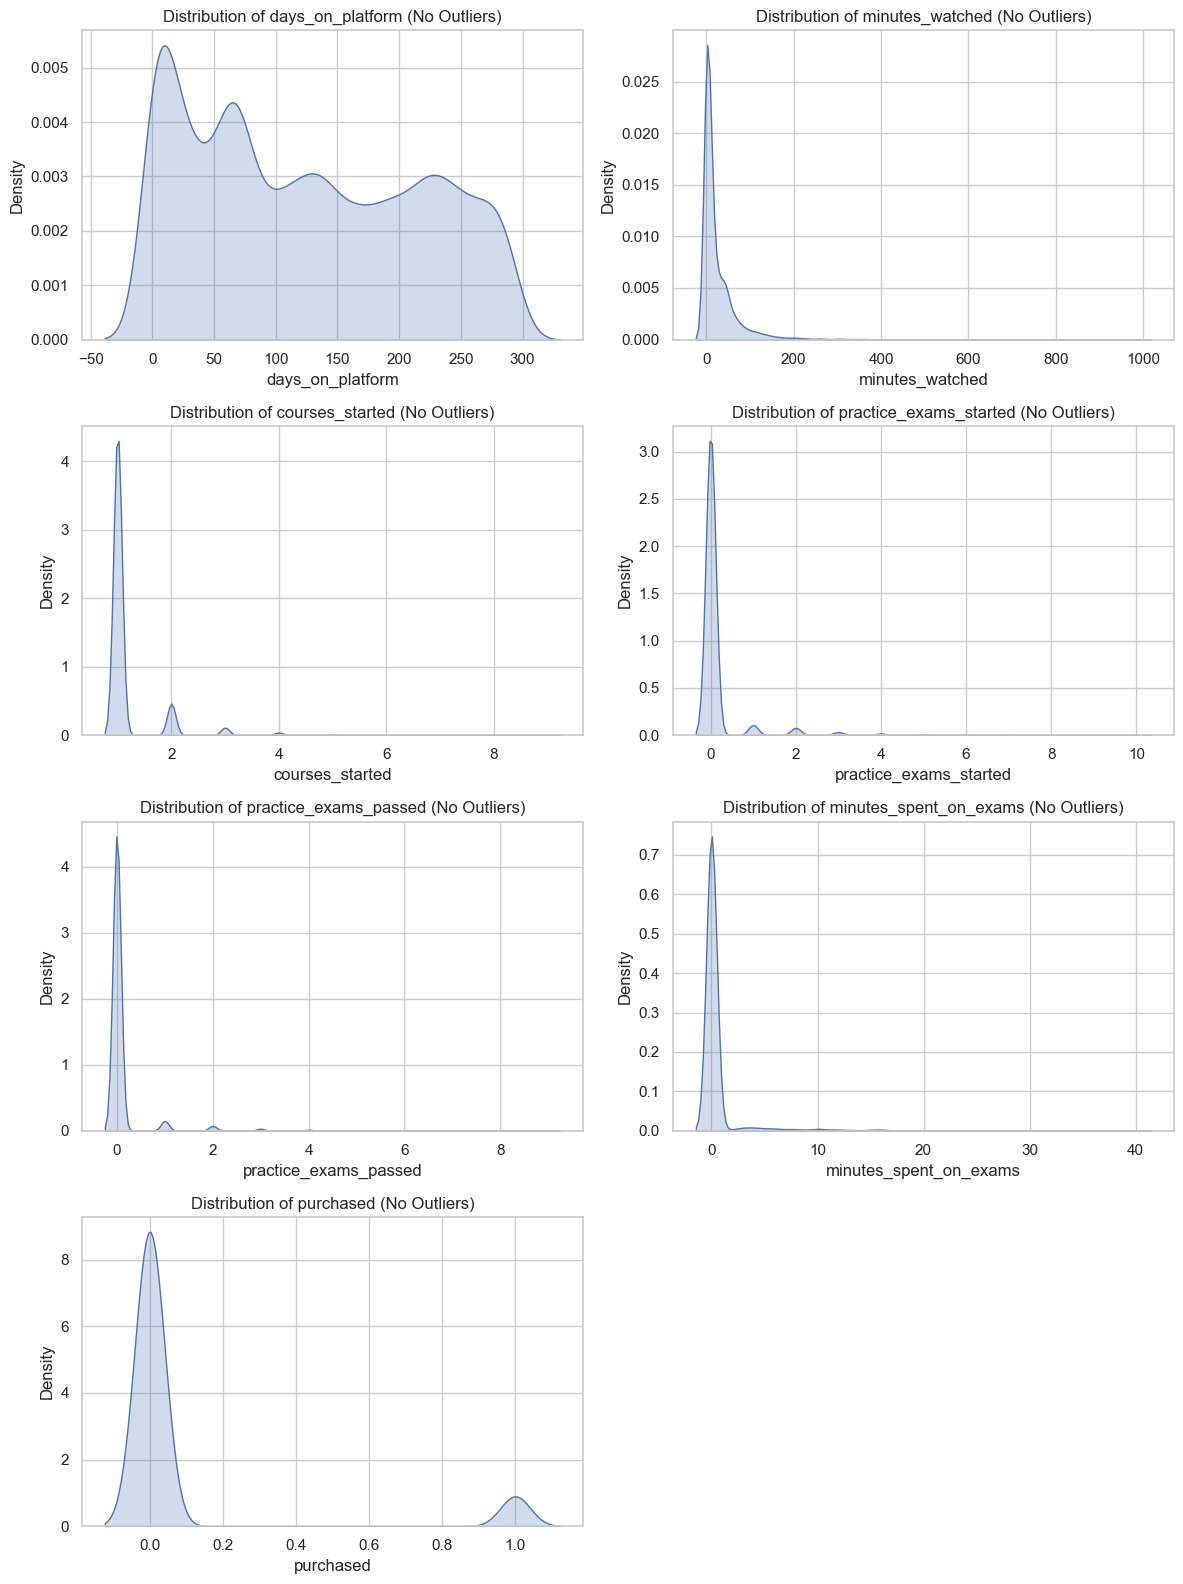

In [7]:
# Step 1: Get the number of features
num_features = len(numerical_features)

# Step 2: Dynamically determine rows & columns
rows = (num_features // 2) + (num_features % 2 > 0)  # Ensures enough rows
cols = min(2, num_features)  # Max 2 columns

# Step 3: Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))  # Adjust height dynamically
axes = axes.flatten()  # Convert to 1D array for easier indexing

# Step 4: Plot KDE distributions for the filtered dataset
for i, feature in enumerate(numerical_features):
    if feature in data_no_outliers.columns:  # Avoid KeyError
        sns.kdeplot(data=data_no_outliers[feature], ax=axes[i], fill=True)
        axes[i].set_title(f"Distribution of {feature} (No Outliers)")
    else:
        print(f"Warning: '{feature}' not found in dataset.")

# Step 5: Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Checking for Multicollinearity

In [8]:

# Step 1: Copy the dataset and select only numerical columns
data_no_mult = data_no_outliers.select_dtypes(include=[np.number]).copy()

# Step 2: Handle NaN values (fill or drop)
data_no_mult = data_no_mult.fillna(0)  # Replace NaN with 0 (or use .dropna())

# Step 3: Convert all data to float64 (ensures compatibility with VIF)
data_no_mult = data_no_mult.astype(float)

# Step 4: Define function to calculate VIF
def calculate_vif(df):
    """Calculates the Variance Inflation Factor (VIF) for each numerical feature."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Step 5: Iteratively remove features with the highest VIF (>5)
while True:
    vif_df = calculate_vif(data_no_mult)
    print("\nVIF values:\n", vif_df)

    # Identify the feature with the highest VIF
    max_vif_feature = vif_df.loc[vif_df["VIF"].idxmax()]

    # If the highest VIF is greater than 5, remove the feature
    if max_vif_feature["VIF"] > 5:
        print(f"Removing feature '{max_vif_feature['Feature']}' with VIF={max_vif_feature['VIF']:.2f}")
        data_no_mult = data_no_mult.drop(columns=[max_vif_feature["Feature"]])
    else:
        break  # Stop when all VIF values are ≤ 5

# Step 6: Display final VIF values after removing multicollinear features
print("\nFinal VIF values (All ≤ 5):\n", calculate_vif(data_no_mult))



VIF values:
                   Feature        VIF
0        days_on_platform   2.494163
1         minutes_watched   1.814420
2         courses_started   3.504408
3  practice_exams_started  10.206234
4   practice_exams_passed   7.829732
5  minutes_spent_on_exams   3.355225
6               purchased   1.229006
Removing feature 'practice_exams_started' with VIF=10.21

VIF values:
                   Feature       VIF
0        days_on_platform  2.492125
1         minutes_watched  1.813759
2         courses_started  3.498304
3   practice_exams_passed  2.569373
4  minutes_spent_on_exams  2.616566
5               purchased  1.228475

Final VIF values (All ≤ 5):
                   Feature       VIF
0        days_on_platform  2.492125
1         minutes_watched  1.813759
2         courses_started  3.498304
3   practice_exams_passed  2.569373
4  minutes_spent_on_exams  2.616566
5               purchased  1.228475


### Dealing with NaN Values

### Splitting the Data

### Encoding the Data

### Creating a Logistic Regression Model

### Creating a K-Nearest Neighbors Model

### Creating a Support Vector Machines Model

### Creating a Decision Trees Model

### Creating a Random Forests Model